In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

# DATA SET PATHS
imgDir = 'images/train2017/'

#download from https://cmu-perceptual-computing-lab.github.io/foot_keypoint_dataset/
annFile_foot = 'annotations/person_keypoints_train2017_foot_v1.json' 

#download from http://cocodataset.org/#download
annFile_body = 'annotations/person_keypoints_train2017.json' 



# GENERATE MODIFIED annFile
# SO THAT CAN BE READ BY COCO DATASET PACKAGE

annFile_foot_modified = 'annotations/person_keypoints_train2017_foot_v1_modified.json' #modified path

with open(annFile_foot) as f:
    data = json.loads(f.read())
    
    #add additional brackets to categories
    data['categories']=[data['categories']] 
    
    #add additional brakets to annotations
    for i in range(len(data['annotations'])):
        if type(data['annotations'][i]['segmentation'][0])!=list:
            data['annotations'][i]['segmentation'] = [data['annotations'][i]['segmentation']] #add additional brackets
    
    #export
    with open(annFile_foot_modified, 'w+') as ff:
        ff.write(json.dumps(data))

# LOAD ANNOTATIONS
coco_foot=COCO(annFile_foot_modified)
print ("no. of CMU foot annotations: %d"%(len(coco_foot.getAnnIds())))

coco_body=COCO(annFile_body)
print ("no. of COCO body annotations: %d"%(len(coco_body.getAnnIds())))

loading annotations into memory...
Done (t=1.13s)
creating index...
index created!
no. of CMU foot annotations: 14758
loading annotations into memory...
Done (t=9.29s)
creating index...
index created!
no. of COCO body annotations: 262465


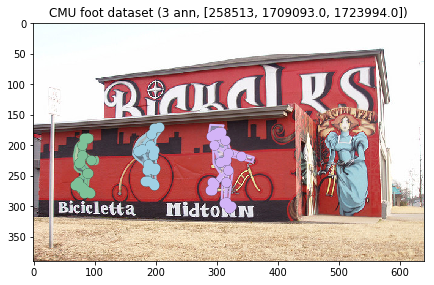

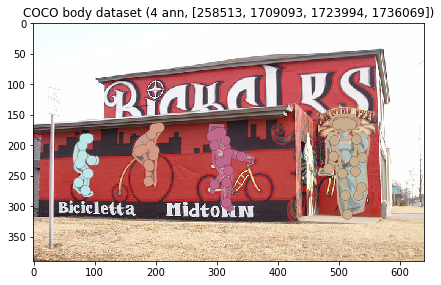

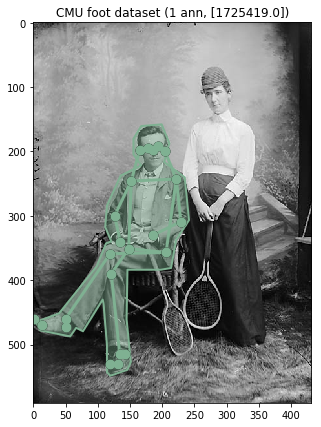

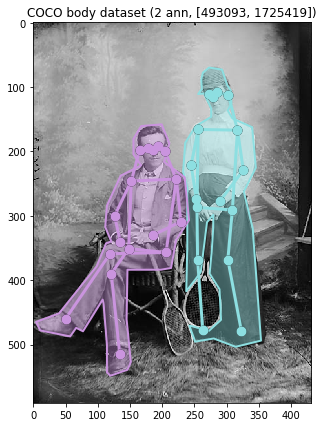

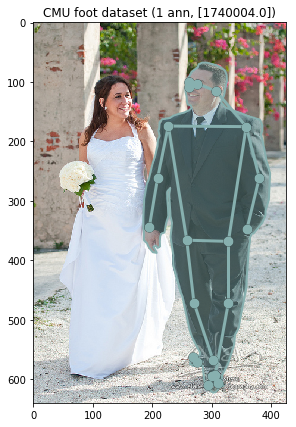

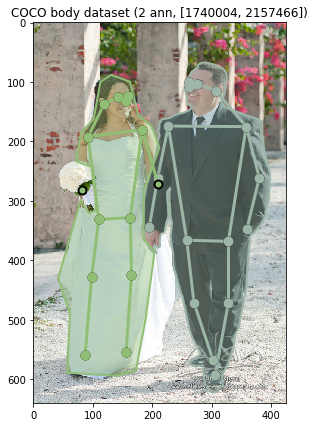

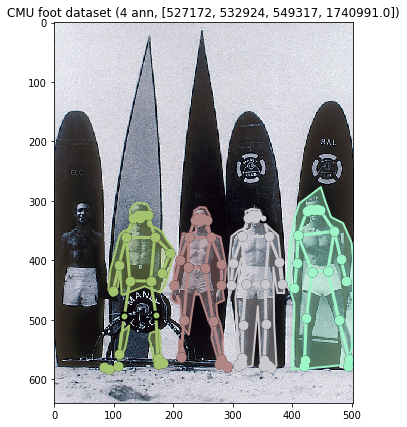

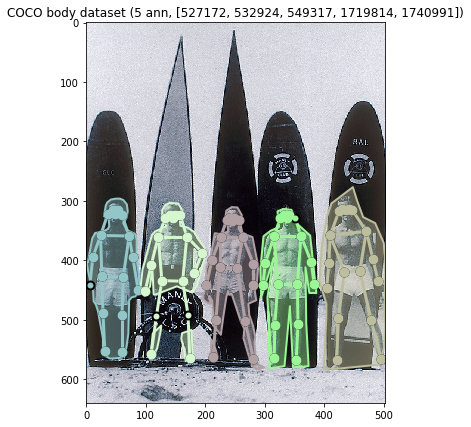

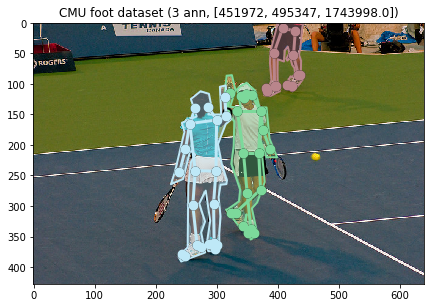

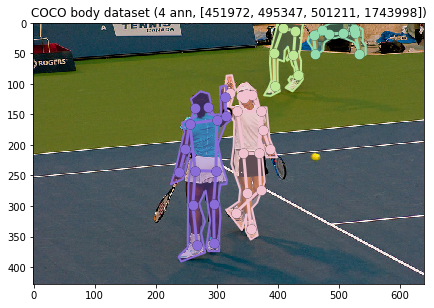

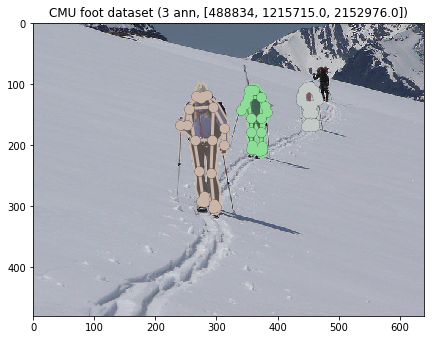

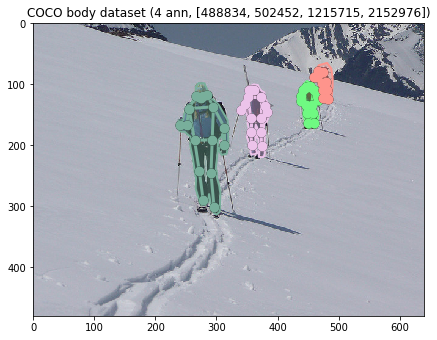

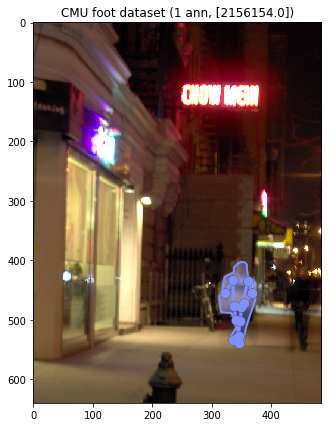

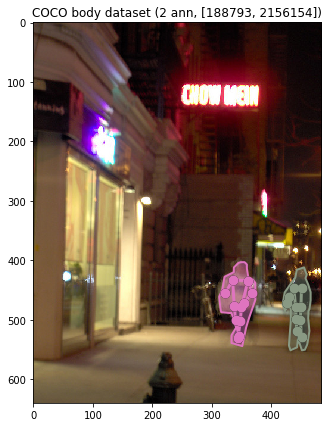

In [3]:
### NUMBERS OF ANNOTATIONS OF AN IMAGE IN COCO BODY AND CMU FOOT ARE DIFFERENT ###

# Selected image ids 
imgids_selected = [522221,502015,559132,395520,429829,455959,548652]

for imgid in imgids_selected:
    #load img
    cvimg = cv2.imread(imgDir+'%012d.jpg'%imgid)
    cvimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)
    
    #plot CMU foot
    anns = coco_foot.loadAnns(coco_foot.getAnnIds(imgIds=[imgid]))
    plt.figure(figsize = (7,7))
    plt.title('CMU foot dataset (%d ann, %s)'%(len(anns), str(coco_foot.getAnnIds(imgIds=[imgid]))))
    plt.imshow(cvimg)
    coco_foot.showAnns(anns)
    
    #plot COCO body
    anns = coco_body.loadAnns(coco_body.getAnnIds(imgIds=[imgid]))
    plt.figure(figsize = (7,7))
    plt.title('COCO body dataset (%d ann, %s)'%(len(anns), str(coco_body.getAnnIds(imgIds=[imgid]))))
    plt.imshow(cvimg)
    coco_body.showAnns(anns)


In [4]:
# Is there any iscrowd annotation in COCO body dataset corresponding to the CMU foot images?

#all image ids
annids = coco_foot.getAnnIds()
imgids = set([ann['image_id'] for ann in coco_foot.loadAnns(annids)])
imgids = set([int(imgid) for imgid in imgids])

#all annids in COCO body
annids_body = coco_body.getAnnIds(imgIds=imgids)

cnt_iscrowd = 0
cnt_notcrowd = 0
for annid in annids_body:
    if (coco_body.loadAnns(annid)[0]['iscrowd']):
        cnt_iscrowd +=1
    else:
        cnt_notcrowd += 1
        
print ("There is %d iscrowd annotation corresponding to the CMU foot images in COCO body dataset"%(cnt_iscrowd))



There is 0 iscrowd annotation corresponding to the CMU foot images in COCO body dataset


Text(0.5,1,'Mask')

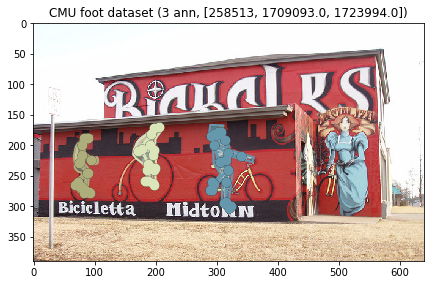

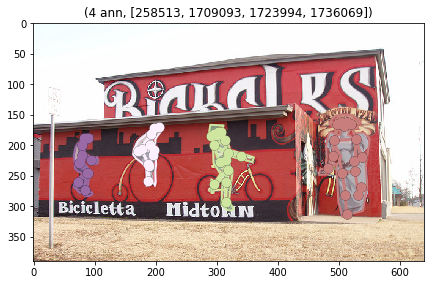

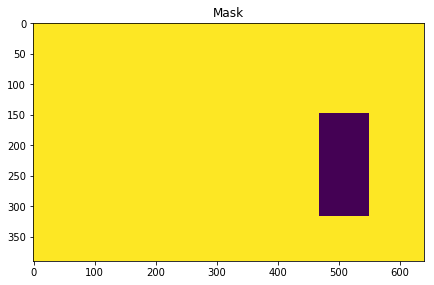

In [5]:
#draw rectangle on the mask
def maskrect(mask,x,y,w,h,val):
    x1, y1 = x, y
    x2, y2 = x1 + w, y1 + h
    mask[int(y1):int(y2),int(x1):int(x2)]=val
    return mask


#MASK GENERATING
imgid =522221

#annotations
ann_foot = coco_foot.getAnnIds(imgIds = [imgid]) #float
ann_foot_int = [int(annid) for annid in ann_foot] #int

ann_body = coco_body.getAnnIds(imgIds = [imgid]) #int

ann_difference = [annid for annid in ann_body if annid not in ann_foot_int]

#initialize mask
img = coco_foot.loadImgs(imgid)[0]
mask = np.ones((img['height'],img['width']))

#mask out ann_difference from coco body
for annid in ann_difference:
    ann = coco_body.loadAnns([annid])[0]
    mask = maskrect(mask, *ann['bbox'], 0)

#enable bbox in ann_foot from cmu foot
for annid in ann_foot:
    ann = coco_foot.loadAnns([annid])[0]
    mask = maskrect(mask, *ann['bbox'], 1)

#PRINTING IMAGES AND MASK
#load image
cvimg = cv2.imread(imgDir+'%012d.jpg'%imgid)
cvimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)

#print CMU foot
anns = coco_foot.loadAnns(coco_foot.getAnnIds(imgIds=[imgid]))
plt.figure(figsize = (7,7))
plt.title('CMU foot dataset (%d ann, %s)'%(len(anns), str(coco_foot.getAnnIds(imgIds=[imgid]))))
plt.imshow(cvimg)
coco_foot.showAnns(anns)

#print coco body
anns = coco_body.loadAnns(coco_body.getAnnIds(imgIds=[imgid]))
plt.figure(figsize = (7,7))
plt.title('(%d ann, %s)'%(len(anns), str(coco_body.getAnnIds(imgIds=[imgid]))))
plt.imshow(cvimg)
coco_body.showAnns(anns)

#print mask
plt.figure(figsize = (7,7));plt.imshow(mask);plt.title('Mask')
